In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras

from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
from keras_unet_collection import layer_utils as k_layers
from keras_unet_collection.activations import GELU

2022-08-06 13:59:30.108470: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [21]:
from tensorflow.keras.utils import to_categorical

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du

In [4]:
filename_train_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*TRAIN*.npy"))
filename_train_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*TRAIN*.npy"))

filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))[::10]
filename_valid_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*VALID*.npy"))[::10]

In [5]:
grid_shape = (128, 128)

label_pos = np.ones(len(filename_valid_pos))
label_neg = np.zeros(len(filename_valid_neg))
VALID_label = np.hstack([label_pos, label_neg])

L_valid = len(VALID_label)

VALID_input = np.empty((L_valid,)+grid_shape+(5,))

for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
    data = np.load(filename)
    VALID_input[i, ...] = data[...]

In [23]:
VALID_label_cate = to_categorical(VALID_label)

In [67]:
from tensorflow.keras.applications import ResNet50

In [68]:
model = ResNet50(include_top=True,
                 weights=None,
                 input_tensor=None,
                 input_shape=(128, 128, 5),
                 pooling=None,
                 classes=2,
                 classifier_activation="softmax",)

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/applications/imagenet_utils.py:331: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 5 input channels.
  warnings.warn('This model usually expects 1 or 3 input channels. '


In [69]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=2e-5))

In [70]:
#model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=1e-5))

In [71]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100
batch_size_half = 50

valid_size = 1

In [72]:

batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'maga_chad'

model_name = '{}_pp5'.format(key)
model_path = temp_dir+model_name

In [73]:
# X_batch = np.empty((batch_size, 128, 128, 5))*np.nan
# Y_batch = np.empty((batch_size, 1))*np.nan

In [74]:
#Y_pred = model.predict([VALID_X])
record = 1.0 #np.nanmean(np.abs(Y_pred-VALID_Y))
print("Initial record: {}".format(record))

Initial record: 1.0


In [75]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [76]:
from sklearn.metrics import classification_report, auc, roc_curve

In [79]:
# ------------------- #
# loop of epoch
#filenames = glob(batch_dir+'TRAIN*.npy')

for i in range(epochs):
    #print('epoch = {}'.format(i))
    start_time = time.time()
    shuffle(filename_train_pos)
    shuffle(filename_train_neg)
    
    # loop of batch
    for j in range(L_train):
        
        shuffle(filename_train_pos)
        shuffle(filename_train_neg)
        
        file_pick_pos = filename_train_pos[:batch_size_half]
        file_pick_neg = filename_train_neg[:batch_size_half]
        
        file_pick = file_pick_pos+file_pick_neg
        
        for k in range(batch_size):
            data = np.load(file_pick[k])
            X_batch[k, ...] = data[...]
        
        Y_batch = np.ones((batch_size, 1))
        Y_batch[batch_size_half:, :] = 0
        
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = to_categorical(Y_batch[ind_, :])
        Y_batch = Y_batch*0.9
        Y_batch[Y_batch==0]=0.09
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([VALID_input])
    Y_pred = Y_pred[:, 1]
    fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
    record_temp = auc(fpr, tpr)
    record_temp = 1 - record_temp
    
    if record - record_temp > min_del:
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))


Validation loss improved from 0.5848685986729866 to 0.2878441625906597
save to: /glade/work/ksha/NCAR/Keras_models/maga_chad_pp5
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/maga_chad_pp5/assets
--- 179.40736842155457 seconds ---
Validation loss improved from 0.2878441625906597 to 0.24790060688382964
save to: /glade/work/ksha/NCAR/Keras_models/maga_chad_pp5
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/maga_chad_pp5/assets
--- 180.29543924331665 seconds ---
Validation loss improved from 0.24790060688382964 to 0.22598451852692258
save to: /glade/work/ksha/NCAR/Keras_models/maga_chad_pp5
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/maga_chad_pp5/assets
--- 181.18434882164001 seconds ---
Validation loss improved from 0.22598451852692258 to 0.19919311081276414
save to: /glade/work/ksha/NCAR/Keras_models/maga_chad_pp5
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/maga_chad_pp5/assets
--- 178.27

KeyboardInterrupt: 

In [80]:
key = 'maga_chad'

model_name = '{}_pp5'.format(key)
model_path = temp_dir+model_name

W = k_utils.dummy_loader(model_path)
model.set_weights(W)

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=1e-5))

model_name = '{}_pp5_tune'.format(key)
model_path = temp_dir+model_name

In [81]:
Y_pred = model.predict([VALID_input])
Y_pred = Y_pred[:, 1]

fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
record_temp = auc(fpr, tpr)
record_temp = 1 - record_temp

print(record_temp)

0.19919311081276414


In [82]:
# ------------------- #
# loop of epoch
#filenames = glob(batch_dir+'TRAIN*.npy')

for i in range(epochs):
    #print('epoch = {}'.format(i))
    start_time = time.time()
    shuffle(filename_train_pos)
    shuffle(filename_train_neg)
    
    # loop of batch
    for j in range(L_train):
        
        shuffle(filename_train_pos)
        shuffle(filename_train_neg)
        
        file_pick_pos = filename_train_pos[:batch_size_half]
        file_pick_neg = filename_train_neg[:batch_size_half]
        
        file_pick = file_pick_pos+file_pick_neg
        
        for k in range(batch_size):
            data = np.load(file_pick[k])
            X_batch[k, ...] = data[...]
        
        Y_batch = np.ones((batch_size, 1))
        Y_batch[batch_size_half:, :] = 0
        
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = to_categorical(Y_batch[ind_, :])
        Y_batch = Y_batch*0.9
        Y_batch[Y_batch==0]=0.09
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([VALID_input])
    Y_pred = Y_pred[:, 1]
    fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
    record_temp = auc(fpr, tpr)
    record_temp = 1 - record_temp
    
    if record - record_temp > min_del:
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

Validation loss improved from 0.19919311081276414 to 0.1936320663044483
save to: /glade/work/ksha/NCAR/Keras_models/maga_chad_pp5_tune
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/maga_chad_pp5_tune/assets
--- 174.56759881973267 seconds ---
Validation loss improved from 0.1936320663044483 to 0.1877632858919731
save to: /glade/work/ksha/NCAR/Keras_models/maga_chad_pp5_tune
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/maga_chad_pp5_tune/assets
--- 174.2535982131958 seconds ---
Validation loss improved from 0.1877632858919731 to 0.1849241316424206
save to: /glade/work/ksha/NCAR/Keras_models/maga_chad_pp5_tune
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/maga_chad_pp5_tune/assets
--- 179.31048703193665 seconds ---
Validation loss improved from 0.1849241316424206 to 0.18060282883291734
save to: /glade/work/ksha/NCAR/Keras_models/maga_chad_pp5_tune
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/

KeyboardInterrupt: 

In [98]:
key = 'maga_chad'

model_name = '{}_pp5_tune'.format(key)
model_path = temp_dir+model_name

W = k_utils.dummy_loader(model_path)
model.set_weights(W)

### Classification results

In [83]:
from sklearn.metrics import classification_report, auc, roc_curve

In [84]:
filename_train_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*TRAIN*.npy"))
filename_train_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*TRAIN*.npy"))

filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))
filename_valid_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*VALID*.npy"))

In [85]:
grid_shape = (128, 128)

label_pos = np.ones(len(filename_valid_pos))
label_neg = np.zeros(len(filename_valid_neg))
VALID_label = np.hstack([label_pos, label_neg])

L_valid = len(VALID_label)

VALID_input = np.empty((L_valid,)+grid_shape+(5,))

for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
    data = np.load(filename)
    VALID_input[i, ...] = data[...]

In [86]:
filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))[::10]
label_pos = np.ones(len(filename_valid_pos))
label_neg = np.zeros(len(filename_valid_neg))
VALID_label_skew = np.hstack([label_pos, label_neg])

L_valid = len(VALID_label_skew)

VALID_skew = np.empty((L_valid,)+grid_shape+(5,))

for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
    data = np.load(filename)
    VALID_skew[i, ...] = data[...]

**Balanced verif**

In [99]:
Y_pred = model.predict([VALID_input])
Y_pred_label = Y_pred > 0.5

In [100]:
Y_pred_label.shape

(55296, 2)

In [101]:
print(classification_report(Y_pred_label[:, 1].ravel(), VALID_label.ravel()))

              precision    recall  f1-score   support

       False       0.94      0.73      0.82     38059
        True       0.60      0.90      0.72     17237

    accuracy                           0.78     55296
   macro avg       0.77      0.81      0.77     55296
weighted avg       0.83      0.78      0.79     55296



In [102]:
fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred[:, 1].ravel())
auc(fpr, tpr)

0.852580221461334

**Natural verif**

In [103]:
Y_pred = model.predict([VALID_skew])
Y_pred_label = Y_pred > 0.5

In [104]:
print(classification_report(Y_pred_label[:, 1].ravel(), VALID_label_skew.ravel()))

              precision    recall  f1-score   support

       False       0.94      0.96      0.95     28844
        True       0.53      0.44      0.48      3124

    accuracy                           0.91     31968
   macro avg       0.73      0.70      0.71     31968
weighted avg       0.90      0.91      0.90     31968



In [105]:
fpr, tpr, thresholds = roc_curve(VALID_label_skew.ravel(), Y_pred[:, 1].ravel())
auc(fpr, tpr)

0.8297336331812817

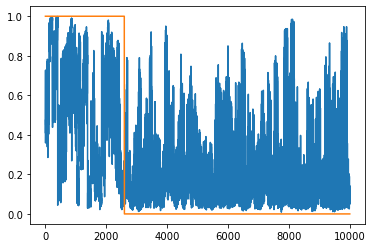

In [106]:
plt.plot(Y_pred[:, 1].ravel()[:10000])
plt.plot(VALID_label_skew.ravel()[:10000])